## Imports & function definitions

In [63]:
import os 
os.chdir('/lustre/scratch/kiviaho/prostate_spatial/')

import scanpy as sc
import numpy as np
import pandas as pd
import anndata as ad
import squidpy as sq


from scipy.stats import fisher_exact
import matplotlib.pyplot as plt
from scripts.utils import load_from_pickle, get_sample_ids_reorder, get_sample_crop_coords, get_sample_id_mask, save_to_pickle
from statsmodels.stats.multitest import multipletests

from itertools import combinations
from scipy.stats import ranksums,kruskal

import seaborn as sns
sns.set_theme()

sc.set_figure_params(figsize=(6,6))

import warnings
warnings.filterwarnings("ignore")

samples = get_sample_ids_reorder()
sample_crop_coord = get_sample_crop_coords()
sample_id_masks = get_sample_id_mask()

sample_categories_dict = {
    'BPH':get_sample_ids_reorder('BPH'),
    'TRNA':get_sample_ids_reorder('untreated'),
    'NEADT':get_sample_ids_reorder(['goserelin','bicalutamide','degarelix','degarelix_apalutamide']),
    'CRPC': get_sample_ids_reorder('CRPC')
}

region_colors_dict = {
    'Tumor': '#fc8d62',
 'Luminal epithelium': '#8da0cb',
 'Basal epithelium': '#66c2a5',
 'Club epithelium': '#ffd92f',
 'Immune': '#a6d854',
 'Endothelium': '#e78ac3',
 'Fibroblast': '#e5c494',
 'Muscle': '#b3b3b3'
 }


## Data download

In [ ]:
# This is the publication iteration of regions
adata_slides = load_from_pickle('./data/slides_with_cell_mapping_based_regions_20240125_tampere_arneo.pkl')

# Get unique region names
regions = adata_slides[samples[5]].obs['predicted_region'].cat.categories.tolist()

# Get unique regions colors
region_colors = adata_slides[samples[5]].uns['predicted_region_colors']

# Create color legend
region_colors = adata_slides[samples[5]].uns['predicted_region_colors']
color_dict = dict(zip(regions,region_colors))

## Defining interfaces & calculating sample-specific receptor-ligand interactions

In [2]:
def get_spot_interfaces(dat, cluster_of_interest, interaction_cluster, annotation_key='predicted_region', added_key='proximity_analysis'):

    # Create an observation column for spatial segmentation
    dat.obs[added_key] = np.nan
    distance_mat = dat.obsp['spatial_distances'].todense()

    for idx, obs_name in enumerate(dat.obs_names):
        cl = dat.obs[annotation_key][idx]

        if cl in [cluster_of_interest, interaction_cluster]:
            first_nhbor_idxs = np.where(distance_mat[:, idx] == 1.0)[0]  # Get first-term neighbor indices

            try:
                n_cl_neighbors = dat[first_nhbor_idxs].obs[annotation_key].value_counts()[cl]  # find first-term neighbor cluster annotations
                all_nhbor_indices = np.where(distance_mat[:, idx] != 0)[0]

                if cl == cluster_of_interest:
                    if (n_cl_neighbors >= 0) & (sum(dat.obs[annotation_key][all_nhbor_indices] == interaction_cluster) >= 2):
                        dat.obs.at[obs_name, added_key] = cl

                elif cl == interaction_cluster:
                    if (n_cl_neighbors >= 0) & (sum(dat.obs[annotation_key][all_nhbor_indices] == cluster_of_interest) >= 2):
                        dat.obs.at[obs_name, added_key] = cl

            except:
                continue

    # Modify the colors to maintain the original cluster color
    dat.obs[added_key] = dat.obs[added_key].astype('category')

    return(dat)



In [16]:
source = 'Club epithelium'
target = 'Immune'
valid_samples = []

it=0
fig, axs = plt.subplots(8, 6, figsize=(18, 24),dpi=120)

for i in range(8):
    for j in range(6):

        if it < len(samples) :
            
            slide = adata_slides[samples[it]]
            # Using three rings you get 6 immediate neigbors, 12 second neigbors and 18 third neighbors
            #sq.gr.spatial_neighbors(slide,n_neighs=6,n_rings=3)
    
            slide = get_spot_interfaces(slide, source, target)

            # Qualify sample only if there are 10 or more of both source and target spots
            if not (slide.obs['proximity_analysis'].isna().all()):
                if (slide.obs['proximity_analysis'].str.contains(source).sum() >= 10) & (slide.obs['proximity_analysis'].str.contains(target).sum() >= 10):
                
                    ## Plotting ##
                    slide.uns['proximity_analysis_colors'] = [color_dict[cat] for cat in slide.obs['proximity_analysis'].cat.categories]

                    # create spatial plot
                    if 'P320' not in samples[it]:
                        sc.pl.spatial(slide,color='proximity_analysis',title=samples[it],
                                                crop_coord=sample_crop_coord[samples[it]],
                                                size=1.5, alpha_img=0, legend_loc=None,na_color='whitesmoke',
                                                ax=axs[i,j],show=False
                                                )

                    else:
                        sc.pl.spatial(slide,color='proximity_analysis',title=samples[it],
                                                size=1.5, alpha_img=0, legend_loc=None,na_color='whitesmoke',
                                                ax=axs[i,j],show=False
                                                )


                    axs[i,j].set_xlabel(None)
                    axs[i,j].set_ylabel(None)

                    # Append this sample to the list
                    valid_samples.append(samples[it])
                else:
                    axs[i,j].set_visible(False)
            else:
                axs[i,j].set_visible(False)
        else:
            axs[i,j].set_visible(False)
        
        it+=1


plt.tight_layout()
plt.savefig('./plots/receptor_ligand_interaction_analysis/'+source+'_'+target+'_proximity_regions.pdf')
#plt.clf()
plt.clf()



<Figure size 2160x2880 with 0 Axes>

In [19]:

#### Second part, using valid_samples to do ligrec #####
ligrec_dict = {}
for sample in valid_samples:

    
    slide = adata_slides[sample].copy()
    slide.obs['proximity_analysis'] = slide.obs['proximity_analysis'].cat.add_categories(['NA'])
    slide.obs['proximity_analysis'] = slide.obs['proximity_analysis'].fillna('NA')

    if (len(slide.obs['proximity_analysis'].cat.categories.tolist()) == 3):
    
        ligrec_res = sq.gr.ligrec(
            slide,
            cluster_key='proximity_analysis',
            clusters = [source,target],
            complex_policy='all',
            show_progress_bar = False,
            n_perms=1000,
            seed=4359345,
            copy=True,
            use_raw=False
        )

        ligrec_dict[sample] = ligrec_res

save_to_pickle(ligrec_dict,'./data/region_ligrec_analysis/'+source+'_'+target+'_slides_with_ligrec.pkl')


In [34]:
# Save the proximal spot annotations
proximity_spot_annots = pd.DataFrame()
for s in valid_samples:
    proximity_spot_annots = pd.concat([
        proximity_spot_annots,
        adata_slides[s].obs.copy()],
        axis=0)

proximity_spot_annots = proximity_spot_annots[['sample_id','predicted_region','proximity_analysis']]
proximity_spot_annots = proximity_spot_annots.rename(columns={'proximity_analysis':'{}_{}_proximity'.format(source,target)})

proximity_spot_annots.to_csv('./data/proximity_spot_ids/{}_to_{}_spot_annotation.csv'.format(source,target))

## Downloading ligand-receptor interaction dictionaries & performing analysis

In [2]:
def get_ligrec_results(results_dict,source_region, target_region, pval = 0.05,reverse=False):
    # Function only reports those means that have a below-threshold p-value

    if reverse:
        source = source_region
        source_region = target_region
        target_region = source

    for i,s in enumerate(list(results_dict.keys())):
        means = results_dict[s]['means'][source_region][target_region]
        pvals = results_dict[s]['pvalues'][source_region][target_region]
        means = pd.DataFrame(means[pvals[pvals<pval].index])
        means = means.rename(columns={target_region:s})
        meta = results_dict[s]['metadata'].loc[means.index]

        if i==0:
            means_all = means
            metas_all = meta
        else:
            means_all = pd.merge(means_all,means,how='outer',left_index=True,right_index=True)
            metas_all = pd.concat([metas_all,meta],axis=0)

    # Drop duplicate indices
    metas_all.drop_duplicates(inplace=True)

    return pd.DataFrame(means_all), metas_all

def summarize_ligrec_results(ligrec_results,ligrec_meta,score_filter=10):
    ## Summarize the ligand-receptor pair results
    df_sum = ligrec_results.copy()
    n_samples = df_sum.shape[1]
    active_in = (~df_sum.isna()).sum(axis=1)
    mean_activity = df_sum.mean(axis=1)
    summarized_ligrec_results = pd.DataFrame({'mean':mean_activity,'active_in':active_in})

    # Filtering interactions according to metadata annotation
    #valid_meta = ligrec_meta[(ligrec_meta['consensus_score_intercell_target']>score_filter) & (ligrec_meta['consensus_score_intercell_source']>score_filter)]
    
    # Updated filtering criteria on 16.4.2024
    # Included n_references filtering
    valid_meta = ligrec_meta[ligrec_meta['n_references']>= 3]
    
    summarized_ligrec_df = summarized_ligrec_results.loc[valid_meta.index.drop_duplicates()]

    # Add columns for ligands and receptors
    summarized_ligrec_df['ligand'] = summarized_ligrec_df.index.get_level_values(0)
    summarized_ligrec_df['receptor'] = summarized_ligrec_df.index.get_level_values(1)

    summarized_ligrec_df = summarized_ligrec_df.sort_values(summarized_ligrec_df.columns[1],ascending=False)

    return summarized_ligrec_df

def check_top_markers(r,p_thresh=0.05):
    # These results rank the deg significance and specificity (low p-value = good marker)
    deg_fishers_res_dict = load_from_pickle('./data/region_gene_markers_fishers_exact_test_240229.pkl')

    fishers_test_df = deg_fishers_res_dict[r].rename(columns={'interaction':'gene','active_in':'deg in'})
    fishers_test_df = fishers_test_df.sort_values('adj_pval').reset_index(drop=True)
    fishers_test_df = fishers_test_df[fishers_test_df['adj_pval'] < p_thresh]

    return fishers_test_df

club_markers_df = check_top_markers('Club epithelium')
marker_genes = club_markers_df['gene'].tolist()


### Club region as source in all samples

In [72]:
interact_with = ['Tumor','Luminal epithelium','Basal epithelium','Immune','Fibroblast','Muscle'] #'Endothelium',

# Club as source in all samples
source = 'Club epithelium'

results_dict = {}
n_interfaces = {}
for target in interact_with:
    dat_dict = load_from_pickle('./data/region_ligrec_analysis/{}_{}_slides_with_ligrec.pkl'.format(source,target))
    
    ligrec_results_out,ligrec_meta_out = get_ligrec_results(dat_dict,source,target,reverse=False) ### REVERSE SWITCH DICTATES WHETHER NAG IS THE SOURCE OR THE TARGET

    summarized_df = summarize_ligrec_results(ligrec_results_out,ligrec_meta_out)
    summarized_df['interaction'] = target
    summarized_df['active_in'] = summarized_df['active_in']/len(dat_dict) # Define whether to normalize by the number samples with region interfaces

    results_dict[target] = summarized_df
    n_interfaces[target] = ligrec_results_out.shape[1]
    
club_as_source_ligrec = results_dict.copy()
total_n_interfaces = sum(n_interfaces.values())

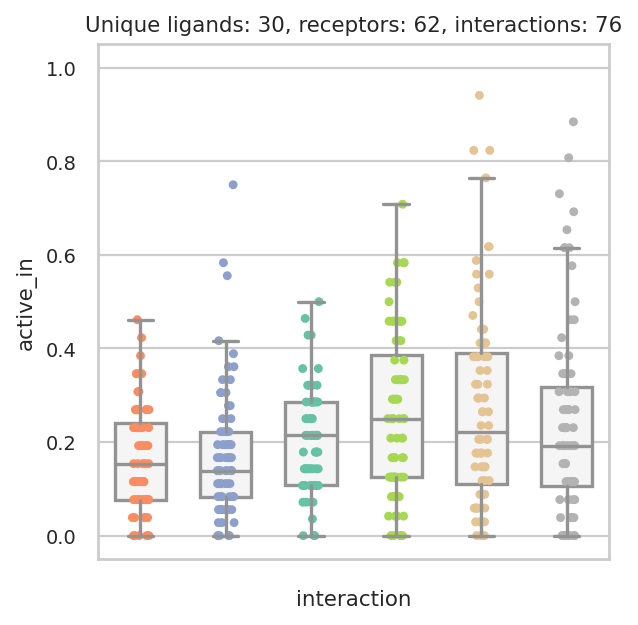

In [73]:
df = pd.concat(club_as_source_ligrec)
df = df[df['ligand'].isin(marker_genes)]

ligands_to_include = df['ligand'].unique()

df = df[df['ligand'].isin(ligands_to_include)]
receptors = sorted(df['receptor'].unique())

df['interaction'] = df['interaction'].astype('category').cat.set_categories(interact_with)


# Create a pivot table to check for missing interactions
pivot_df = df.pivot_table(index=['ligand', 'receptor'], columns='interaction', values='active_in', fill_value=0)

# Convert the pivot table back to a dataframe
result_df = pivot_df.stack().reset_index()
result_df.columns = ['ligand', 'receptor', 'interaction', 'active_in']

title = 'Unique ligands: {}, receptors: {}, interactions: {}'.format(
    len(result_df['ligand'].unique()),
    len(result_df['receptor'].unique()),
    len((result_df['ligand']+'_'+result_df['receptor']).unique())
    )

# Plot the boxplot

# Plot the boxplot

sns.set_theme(
            style='whitegrid',
            font_scale=0.8
            )
sns.set_palette(palette=sns.color_palette([region_colors_dict[r] for r in interact_with]))

fig, ax = plt.subplots(figsize=(4,4))
sns.stripplot(result_df,x='interaction',y='active_in',size=4,hue='interaction',ax=ax,legend=False)
sns.boxplot(showmeans=False,
        meanline=False,
        meanprops={'color': 'k', 'ls': '-', 'lw': 2},
        medianprops={'visible': True},
        whiskerprops={'visible': True},
        zorder=10,
        x="interaction",
        y="active_in",
        data=result_df,
        showfliers=False,
        showbox=True,
        showcaps=True,
        color='whitesmoke',
        width=0.6,
        ax=ax)

ax.set_ylim(-0.05,1.05)
#ax.set_xticklabels(ax.get_xticklabels(),rotation=20)
ax.set_xticklabels('')
ax.set_title(title)

plt.tight_layout()

plt.savefig('./plots/receptor_ligand_interaction_analysis/Club_epithelium_as_source_ligrec_pct.pdf')
plt.savefig('./plots/receptor_ligand_interaction_analysis/Club_epithelium_as_source_ligrec_pct.png')
plt.show()


In [75]:

result_df['n_interfaces_with_club'] = result_df['interaction'].map(n_interfaces)


# Calculate p-values for overrepresentation of individual pathways
list_of_pvals = []
for i, row in result_df.iterrows():
    df = result_df[(result_df['ligand'] == row['ligand']) & (result_df['receptor'] == row['receptor'])]
    df = df[~(df['interaction'] ==row['interaction'])]

    a = row['active_in'] * row['n_interfaces_with_club']
    b = row['n_interfaces_with_club'] - a
    c = (df['active_in'] * df['n_interfaces_with_club']).sum()
    d = df['n_interfaces_with_club'].sum() - c

    arr = np.array([[a,b],[c,d]])
    arr

    stat, pval = fisher_exact(arr,alternative='greater')

    list_of_pvals.append(pval)

result_df['overrep_test_adj_pval'] = multipletests(list_of_pvals,method='fdr_bh')[1]

result_df = result_df.sort_values('overrep_test_adj_pval',ascending=True).reset_index(drop=True)


dict_with_final_ligrec_results = {}
dict_with_final_ligrec_results['club_as_source'] = result_df

# Save the results
#result_df.to_excel('./source_data/club_as_source_ligand_receptor_activity.xlsx')


In [76]:
from itertools import combinations
from scipy.stats import ranksums,kruskal


# Perform Kruskal-Wallis H-test
interaction_categories = result_df['interaction'].unique()
grouped_data = [result_df[result_df['interaction'] == category]['active_in'] for category in interaction_categories]
test_statistic, p_value = kruskal(*grouped_data)
print(f"Kruskal-Wallis H-test: test statistic = {test_statistic:.4f}, p-value = {p_value:.4f}")


# Perform pairwise Wilcoxon rank-sums tests
interaction_categories = result_df['interaction'].unique()
pairwise_tests = list(combinations(interaction_categories, 2))

# Collect p-values and test statistics
test_results = []
for category1, category2 in pairwise_tests:
    group1 = result_df[result_df['interaction'] == category1]['active_in']
    group2 = result_df[result_df['interaction'] == category2]['active_in']
    test_statistic, p_value = ranksums(group1, group2)
    test_results.append({'Category1': category1, 'Category2': category2, 'TestStatistic': test_statistic, 'p-value': p_value})

# Create a dataframe from the test results
test_results = pd.DataFrame(test_results).sort_values('p-value').reset_index(drop=True)
print(test_results)


Kruskal-Wallis H-test: test statistic = 19.1446, p-value = 0.0018
             Category1           Category2  TestStatistic   p-value
0               Immune               Tumor       3.285131  0.001019
1           Fibroblast  Luminal epithelium       2.999547  0.002704
2           Fibroblast               Tumor       2.936903  0.003315
3   Luminal epithelium              Immune      -2.741601  0.006114
4   Luminal epithelium    Basal epithelium      -2.052516  0.040120
5               Muscle               Tumor       1.943810  0.051918
6   Luminal epithelium              Muscle      -1.908803  0.056288
7     Basal epithelium               Tumor       1.781672  0.074803
8           Fibroblast    Basal epithelium       1.556890  0.119497
9               Immune    Basal epithelium       1.536623  0.124386
10          Fibroblast              Muscle       0.923079  0.355966
11              Immune              Muscle       0.875175  0.381479
12              Muscle    Basal epithelium       0

In [77]:
# Updated the naming scheme on 16.4.2024
pd.concat(club_as_source_ligrec).to_csv('./plots/receptor_ligand_interaction_analysis/{}_as_source_ligand_receptor_results.csv'.format(source.replace(' ','_')))

### Club region as target in all regions

In [78]:

# Club as target in all samples
source = 'Club epithelium'

results_dict = {}
for target in interact_with:
    dat_dict = load_from_pickle('./data/region_ligrec_analysis/{}_{}_slides_with_ligrec.pkl'.format(source,target))
    
    ligrec_results_out,ligrec_meta_out = get_ligrec_results(dat_dict,source,target,reverse=True) ### REVERSE SWITCH DICTATES WHETHER NAG IS THE SOURCE OR THE TARGET

    summarized_df = summarize_ligrec_results(ligrec_results_out,ligrec_meta_out)
    summarized_df['interaction'] = target
    summarized_df['active_in'] = summarized_df['active_in']/len(dat_dict) # Define whether to normalize by the number samples with region interfaces

    results_dict[target] = summarized_df

club_as_target_ligrec = results_dict.copy()
    

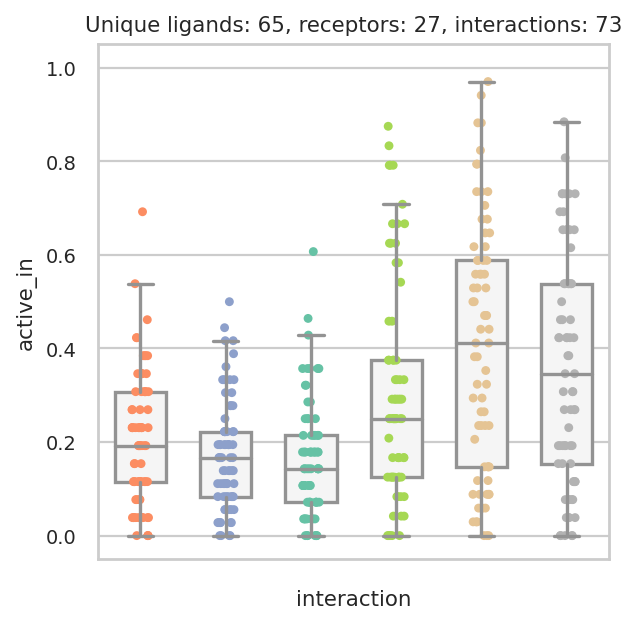

In [79]:
df = pd.concat(club_as_target_ligrec)
df = df[df['receptor'].isin(marker_genes)]

receptors_to_include = df['receptor'].unique()

df = df[df['receptor'].isin(receptors_to_include)]
receptors = sorted(df['receptor'].unique())

df['interaction'] = df['interaction'].astype('category').cat.set_categories(interact_with)


# Create a pivot table to check for missing interactions
pivot_df = df.pivot_table(index=['ligand', 'receptor'], columns='interaction', values='active_in', fill_value=0)

# Convert the pivot table back to a dataframe
result_df = pivot_df.stack().reset_index()
result_df.columns = ['ligand', 'receptor', 'interaction', 'active_in']

title = 'Unique ligands: {}, receptors: {}, interactions: {}'.format(
    len(result_df['ligand'].unique()),
    len(result_df['receptor'].unique()),
    len((result_df['ligand']+'_'+result_df['receptor']).unique())
    )

# Plot the boxplot

sns.set_theme(
            style='whitegrid',
            font_scale=0.8
            )
sns.set_palette(palette=sns.color_palette([region_colors_dict[r] for r in interact_with]))

fig, ax = plt.subplots(figsize=(4,4))
sns.stripplot(result_df,x='interaction',y='active_in',size=4,hue='interaction',ax=ax,legend=False)
sns.boxplot(showmeans=False,
        meanline=False,
        meanprops={'color': 'k', 'ls': '-', 'lw': 2},
        medianprops={'visible': True},
        whiskerprops={'visible': True},
        zorder=10,
        x="interaction",
        y="active_in",
        data=result_df,
        showfliers=False,
        showbox=True,
        showcaps=True,
        color='whitesmoke',
        width=0.6,
        ax=ax)

ax.set_ylim(-0.05,1.05)

#ax.set_xticklabels(ax.get_xticklabels(),rotation=20)
ax.set_xticklabels('')
ax.set_title(title)

plt.tight_layout()
plt.savefig('./plots/receptor_ligand_interaction_analysis/Club_epithelium_as_target_ligrec_pct.pdf')
plt.savefig('./plots/receptor_ligand_interaction_analysis/Club_epithelium_as_target_ligrec_pct.png')
plt.show()



In [80]:

result_df['n_interfaces_with_club'] = result_df['interaction'].map(n_interfaces)  # Add a column with info on the number of interfaces

# Calculate p-values for overrepresentation of individual ligand-receptor interactions
list_of_pvals = []
for i, row in result_df.iterrows():
    df = result_df[(result_df['ligand'] == row['ligand']) & (result_df['receptor'] == row['receptor'])]
    df = df[~(df['interaction'] ==row['interaction'])]

    a = row['active_in'] * row['n_interfaces_with_club']
    b = row['n_interfaces_with_club'] - a
    c = (df['active_in'] * df['n_interfaces_with_club']).sum()
    d = df['n_interfaces_with_club'].sum() - c

    arr = np.array([[a,b],[c,d]])
    arr

    stat, pval = fisher_exact(arr,alternative='greater')

    list_of_pvals.append(pval)

result_df['overrep_test_adj_pval'] = multipletests(list_of_pvals,method='fdr_bh')[1]

result_df = result_df.sort_values('overrep_test_adj_pval',ascending=True).reset_index(drop=True)

dict_with_final_ligrec_results['club_as_target'] = result_df
# Save the results
#result_df.to_excel('./source_data/club_as_target_ligand_receptor_activity.xlsx')


In [81]:
# Perform Kruskal-Wallis H-test
interaction_categories = result_df['interaction'].unique()
grouped_data = [result_df[result_df['interaction'] == category]['active_in'] for category in interaction_categories]
test_statistic, p_value = kruskal(*grouped_data)
print(f"Kruskal-Wallis H-test: test statistic = {test_statistic:.4f}, p-value = {p_value:.4f}")


# Perform pairwise Wilcoxon rank-sums tests
interaction_categories = result_df['interaction'].unique()
pairwise_tests = list(combinations(interaction_categories, 2))

# Collect p-values and test statistics
test_results = []
for category1, category2 in pairwise_tests:
    group1 = result_df[result_df['interaction'] == category1]['active_in']
    group2 = result_df[result_df['interaction'] == category2]['active_in']
    test_statistic, p_value = ranksums(group1, group2)
    test_results.append({'Category1': category1, 'Category2': category2, 'stat': test_statistic, 'p-value': p_value})

# Create a dataframe from the test results
test_results = pd.DataFrame(test_results).sort_values('p-value').reset_index(drop=True)
print(test_results)


Kruskal-Wallis H-test: test statistic = 59.2094, p-value = 0.0000
             Category1           Category2      stat       p-value
0           Fibroblast    Basal epithelium  5.111546  3.195330e-07
1           Fibroblast  Luminal epithelium  5.027397  4.971817e-07
2               Muscle    Basal epithelium  4.923679  8.493209e-07
3   Luminal epithelium              Muscle -4.344423  1.396424e-05
4           Fibroblast               Tumor  4.272016  1.937140e-05
5               Immune    Basal epithelium  4.203523  2.627930e-05
6   Luminal epithelium              Immune -3.808219  1.399712e-04
7               Muscle               Tumor  3.616438  2.986844e-04
8               Immune               Tumor  2.788650  5.292828e-03
9     Basal epithelium               Tumor -2.146771  3.181151e-02
10          Fibroblast              Immune  1.780822  7.494155e-02
11  Luminal epithelium               Tumor -1.414873  1.571058e-01
12              Immune              Muscle -1.107632  2.680207e

In [82]:
# Updated the naming scheme on 16.4.2024
pd.concat(club_as_target_ligrec).to_csv('./plots/receptor_ligand_interaction_analysis/{}_as_target_ligand_receptor_results.csv'.format(source.replace(' ','_')))

### Save both the tables into a single excel table

In [83]:
# Create a Pandas Excel writer using XlsxWriter as the engine
writer = pd.ExcelWriter('./supplementary_tables/club_regions_ligand_receptor_analysis.xlsx', engine='xlsxwriter')

# Write each dataframe to a different worksheet
for sheet_name, df in dict_with_final_ligrec_results.items():
    df.to_excel(writer, sheet_name=sheet_name, index=False)

# Close the Pandas Excel writer and output the Excel file
writer.save()

## The club region as source – treated & untreated

In [75]:
def get_ligrec_results(results_dict,source_region, target_region, pval = 0.05,reverse=False):
    # Function only reports those means that have a below-threshold p-value

    if reverse:
        source = source_region
        source_region = target_region
        target_region = source

    for i,s in enumerate(list(results_dict.keys())):
        means = results_dict[s]['means'][source_region][target_region]
        pvals = results_dict[s]['pvalues'][source_region][target_region]
        means = pd.DataFrame(means[pvals[pvals<pval].index])
        means = means.rename(columns={target_region:s})
        meta = results_dict[s]['metadata'].loc[means.index]

        if i==0:
            means_all = means
            metas_all = meta
        else:
            means_all = pd.merge(means_all,means,how='outer',left_index=True,right_index=True)
            metas_all = pd.concat([metas_all,meta],axis=0)

    # Drop duplicate indices
    metas_all.drop_duplicates(inplace=True)

    return pd.DataFrame(means_all), metas_all

def summarize_ligrec_results_modified(ligrec_results,ligrec_meta, sample_cats = sample_categories_dict):
    ## Summarize the ligand-receptor pair results
    df_sum = ligrec_results.copy()

    active_in = (~df_sum.isna()).sum(axis=1)
    mean_activity = df_sum.mean(axis=1)
    summarized_ligrec_results = pd.DataFrame({'mean_total':mean_activity,'active_in_total':active_in})

    active_by_category = pd.DataFrame()
    for key1 in sample_cats:
        keys_lst = sample_cats[key1]
        keys_lst = [k for k in keys_lst if k in ligrec_results.columns.tolist()]
        df = ligrec_results[keys_lst]
        active_by_category[key1+'_active_in'] = (~(df.isna())).sum(axis=1)# / len(keys_lst)
    
    summarized_ligrec_results = pd.concat([summarized_ligrec_results,active_by_category],axis=1)
    
    # Updated filtering criteria on 16.4.2024
    # Included n_references filtering
    valid_meta = ligrec_meta[ligrec_meta['n_references']>= 5]
    
    summarized_ligrec_df = summarized_ligrec_results.loc[valid_meta.index.drop_duplicates()]

    summarized_ligrec_df = summarized_ligrec_df.sort_values(summarized_ligrec_df.columns[1],ascending=False)

    return summarized_ligrec_df



In [76]:
interact_with = ['Tumor','Luminal epithelium','Basal epithelium','Immune','Fibroblast','Muscle']

# Club as source in all samples
source = 'Club epithelium'

results_dict = {}
n_interfaces = {}
for target in interact_with:
    dat_dict = load_from_pickle('./data/region_ligrec_analysis/{}_{}_slides_with_ligrec.pkl'.format(source,target))
    
    ligrec_results_out,ligrec_meta_out = get_ligrec_results(dat_dict,source,target,reverse=False) ### REVERSE SWITCH DICTATES WHETHER NAG IS THE SOURCE OR THE TARGET

    summarized_df = summarize_ligrec_results_modified(ligrec_results_out,ligrec_meta_out)
    summarized_df['interaction'] = target

    results_dict[target] = summarized_df
    n_interfaces[target] = ligrec_results_out.shape[1]
    
club_as_source_ligrec = results_dict.copy()
total_n_interfaces = sum(n_interfaces.values())

In [132]:

df = pd.concat(club_as_source_ligrec)
#df = club_as_source_ligrec[region]

# Add columns for ligands and receptors
df['ligand'] = df.index.get_level_values('source')
df['receptor'] = df.index.get_level_values('target')
""" 
df = df.groupby(['ligand','receptor']).aggregate({
    'mean_total':'mean',
    'active_in_total':'sum',
    'BPH_active_in':'sum',
    'TRNA_active_in':'sum',
    'NEADT_active_in':'sum',
    'CRPC_active_in':'sum'
})
 """
df['TRNA_NEADT_diff'] = df['TRNA_active_in'] - df['NEADT_active_in']

df = df.sort_values('TRNA_NEADT_diff',ascending=True)

df = pd.concat([df[:10],df[-10:]],axis=0)

for idx,row in df.iterrows():
    a = row['TRNA_active_in']
    b = len(sample_categories_dict['TRNA']) - a
    c = row['NEADT_active_in']
    d = len(sample_categories_dict['NEADT']) - c
    arr = np.array([[a,b],[c,d]])

    stat, pval = fisher_exact(arr)
    if pval < 0.05:
        print('{} p-value: {:.2e} !!'.format(row.name,pval)) 
    else:
        print('{} p-value: {:.2e}'.format(row.name,pval)) 

('Immune', 'ALCAM', 'CD6') p-value: 3.32e-03 !!
('Immune', 'NECTIN2', 'TIGIT') p-value: 1.73e-02 !!
('Fibroblast', 'PDGFA', 'PDGFRA') p-value: 2.44e-02 !!
('Fibroblast', 'PDGFB', 'PDGFRB') p-value: 1.73e-02 !!
('Fibroblast', 'EFNA4', 'EPHA7') p-value: 1.06e-02 !!
('Fibroblast', 'ADM', 'RAMP1') p-value: 4.90e-02 !!
('Muscle', 'CALCA', 'RAMP1') p-value: 2.40e-02 !!
('Basal epithelium', 'ADM', 'RAMP3') p-value: 5.59e-03 !!
('Fibroblast', 'APOE', 'LRP1') p-value: 3.65e-02 !!
('Fibroblast', 'EFNA4', 'EPHA3') p-value: 4.90e-02 !!
('Tumor', 'TNFSF15', 'TNFRSF25') p-value: 6.84e-02
('Luminal epithelium', 'IL1B', 'IL1RAP') p-value: 6.84e-02
('Luminal epithelium', 'IL1B', 'TYK2') p-value: 6.84e-02
('Luminal epithelium', 'TNFSF10', 'TNFRSF10D') p-value: 6.84e-02
('Immune', 'ICOSLG', 'ICOS') p-value: 6.84e-02
('Tumor', 'IL1B', 'TYK2') p-value: 2.89e-02 !!
('Luminal epithelium', 'CXCL2', 'ACKR1') p-value: 6.84e-02
('Luminal epithelium', 'TGFB2', 'TGFBR1') p-value: 6.84e-02
('Luminal epithelium', 'T

## Deprecated

In [ ]:
### Club as source overrepresentation analysis
# Download and format normals
club_as_source = pd.read_csv('./Club_epithelium_as_source_ligand_receptor_results.csv',index_col=0) # Updated on 16.4.2024
mean_mapping_df = club_as_source[['source','target','mean','interaction']].set_index(['source','target'])
club_as_source = club_as_source[['source','target','active_in']].reset_index(names='region')

all_res = pd.DataFrame()
#roi = 'Immune'

for roi in regions:
    # Create a results dict structure
    interactions = pd.Series([(club_as_source['source'].iloc[i], club_as_source['target'].iloc[i]) for i in range(len(club_as_source))]).unique().tolist()
    res_df = pd.DataFrame({'active_in':0,'p_val':1},index=interactions)

    total_n_roi = n_interfaces_dict[roi]
    total_n_others = np.sum([n_interfaces_dict[r] for r in regions if r != roi])

    for source, target in interactions:

        df = club_as_source[(club_as_source['source'] == source) & (club_as_source['target'] == target)].reset_index(drop=True)

        # Amend the dataframe for missing region information
        for reg in regions:
            if not (df['region'].isin([reg])).any():
                df = df.append({'region':reg,'source':source,'target':target,'active_in':0},ignore_index=True)
        df = df.set_index('region')

        # Build the array
        a = df.loc[roi,'active_in']
        c = df.drop(roi)['active_in'].sum()
        b = total_n_roi - a
        d = total_n_others - c
        arr = np.array([[a,b],[c,d]])

        # Run Fisher's exact
        stat, pval = fisher_exact(arr,alternative='greater')

        res_df.loc[[(source,target)],'active_in'] = a
        res_df.loc[[(source,target)],'p_val'] = pval

    res_df['adj_pval'] = multipletests(res_df['p_val'],method='fdr_bh')[1]

    #res_df['source'] = [a for a,b in res_df.index]
    #res_df['target'] = [b for a,b in res_df.index]
    #res_df = res_df.reset_index(drop=True)

    res_df = res_df.sort_values('adj_pval')
    res_df['interaction_region'] = roi
    all_res = pd.concat([all_res,res_df],axis=0)

all_res.to_excel('club_as_source_raw_enrichment_results_updated.xlsx')

plot_df = all_res[all_res['adj_pval'] < 0.05].copy()
plot_df['log_adj_pval'] = -np.log10(plot_df['adj_pval'])

# Add the mean values from a dataframe
mean_values = []
for idx, row in plot_df.iterrows():
    mean_values.append(mean_mapping_df[mean_mapping_df['interaction']==row['interaction_region']].loc[[idx],'mean'][0])

plot_df['mean'] = mean_values

plot_df['interaction_region'] = plot_df['interaction_region'].astype('category').cat.set_categories(region_colors_dict.keys())
fig, ax = plt.subplots(figsize=(5,5))

sns.scatterplot(data=plot_df,x='mean',y='log_adj_pval',hue='interaction_region',size='active_in',
    sizes=(10,100),legend=False, ax = ax
    )
plt.savefig('./club_as_source_all_overrepresentation_scatterplot_updated.pdf',transparent=True)
plt.show()
fig, ax = plt.subplots(figsize=(20,20))

sns.scatterplot(data=plot_df,x='mean',y='log_adj_pval',hue='interaction_region',size='active_in',
    sizes=(10,100),legend=False, ax = ax
    )

# add annotations one by one with a loop
for line in range(0,plot_df.shape[0]):
    plt.text(plot_df['mean'][line]+0.02, plot_df.log_adj_pval[line], plot_df.index[line], horizontalalignment='left', size='small', color='black', weight='light')

plt.show()
plot_df[['interaction_region','mean','log_adj_pval','active_in']].sort_values('log_adj_pval',ascending=False).to_excel('./club_as_source_fishers_ligrec_overrep_analysis_res_updated.xlsx')
plot_df['interaction_region'].value_counts()
plot_df.groupby('interaction_region').mean().sort_values('mean',ascending=False)
plot_df.groupby('interaction_region').mean().sort_values('log_adj_pval',ascending=False)
### Club as target overrepresentation analysis
# Download and format normals
club_as_target = pd.read_csv('./Club_epithelium_as_target_ligand_receptor_results.csv',index_col=0)
mean_mapping_df = club_as_target[['source','target','mean','interaction']].set_index(['source','target'])
club_as_target = club_as_target[['source','target','active_in']].reset_index(names='region')

all_res = pd.DataFrame()
#roi = 'Immune'

for roi in regions:
    # Create a results dict structure
    interactions = pd.Series([(club_as_target['source'].iloc[i], club_as_target['target'].iloc[i]) for i in range(len(club_as_target))]).unique().tolist()
    res_df = pd.DataFrame({'active_in':0,'p_val':1},index=interactions)

    total_n_roi = n_interfaces_dict[roi]
    total_n_others = np.sum([n_interfaces_dict[r] for r in regions if r != roi])

    for source, target in interactions:

        df = club_as_target[(club_as_target['source'] == source) & (club_as_target['target'] == target)].reset_index(drop=True)

        # Amend the dataframe for missing region information
        for reg in regions:
            if not (df['region'].isin([reg])).any():
                df = df.append({'region':reg,'source':source,'target':target,'active_in':0},ignore_index=True)
        df = df.set_index('region')

        # Build the array
        a = df.loc[roi,'active_in']
        c = df.drop(roi)['active_in'].sum()
        b = total_n_roi - a
        d = total_n_others - c
        arr = np.array([[a,b],[c,d]])

        # Run Fisher's exact
        stat, pval = fisher_exact(arr,alternative='greater')

        res_df.loc[[(source,target)],'active_in'] = a
        res_df.loc[[(source,target)],'p_val'] = pval

    res_df['adj_pval'] = multipletests(res_df['p_val'],method='fdr_bh')[1]

    #res_df['source'] = [a for a,b in res_df.index]
    #res_df['target'] = [b for a,b in res_df.index]
    #res_df = res_df.reset_index(drop=True)

    res_df = res_df.sort_values('adj_pval')
    res_df['interaction_region'] = roi
    all_res = pd.concat([all_res,res_df],axis=0)

plot_df = all_res[all_res['adj_pval'] < 0.05].copy()
plot_df['log_adj_pval'] = -np.log10(plot_df['adj_pval'])

# Add the mean values from a dataframe
mean_values = []
for idx, row in plot_df.iterrows():
    mean_values.append(mean_mapping_df[mean_mapping_df['interaction']==row['interaction_region']].loc[[idx],'mean'][0])

plot_df['mean'] = mean_values

plot_df['interaction_region'] = plot_df['interaction_region'].astype('category').cat.set_categories(region_colors_dict.keys())
fig, ax = plt.subplots(figsize=(5,5))

sns.scatterplot(data=plot_df,x='mean',y='log_adj_pval',hue='interaction_region',size='active_in',
    sizes=(10,100),legend=False, ax = ax
    )
plt.savefig('./club_as_target_all_overrepresentation_scatterplot_updated.pdf',transparent=True)
plt.show()
fig, ax = plt.subplots(figsize=(20,20))

sns.scatterplot(data=plot_df,x='mean',y='log_adj_pval',hue='interaction_region',size='active_in',
    sizes=(10,100),legend=False, ax = ax
    )

# add annotations one by one with a loop
for line in range(0,plot_df.shape[0]):
    plt.text(plot_df['mean'][line]+0.02, plot_df.log_adj_pval[line], plot_df.index[line], horizontalalignment='left', size='small', color='black', weight='light')

plt.show()
plot_df[['interaction_region','mean','log_adj_pval','active_in']].sort_values('log_adj_pval',ascending=False).to_excel('./club_as_target_fishers_ligrec_overrep_analysis_res_updated.xlsx')
plot_df['interaction_region'].value_counts()
plot_df.groupby('interaction_region').mean().sort_values('mean',ascending=False)
plot_df.groupby('interaction_region').mean().sort_values('log_adj_pval',ascending=False)